This is used to do all of the imports that is required to make stuff work


GeoJSON loaded successfully!


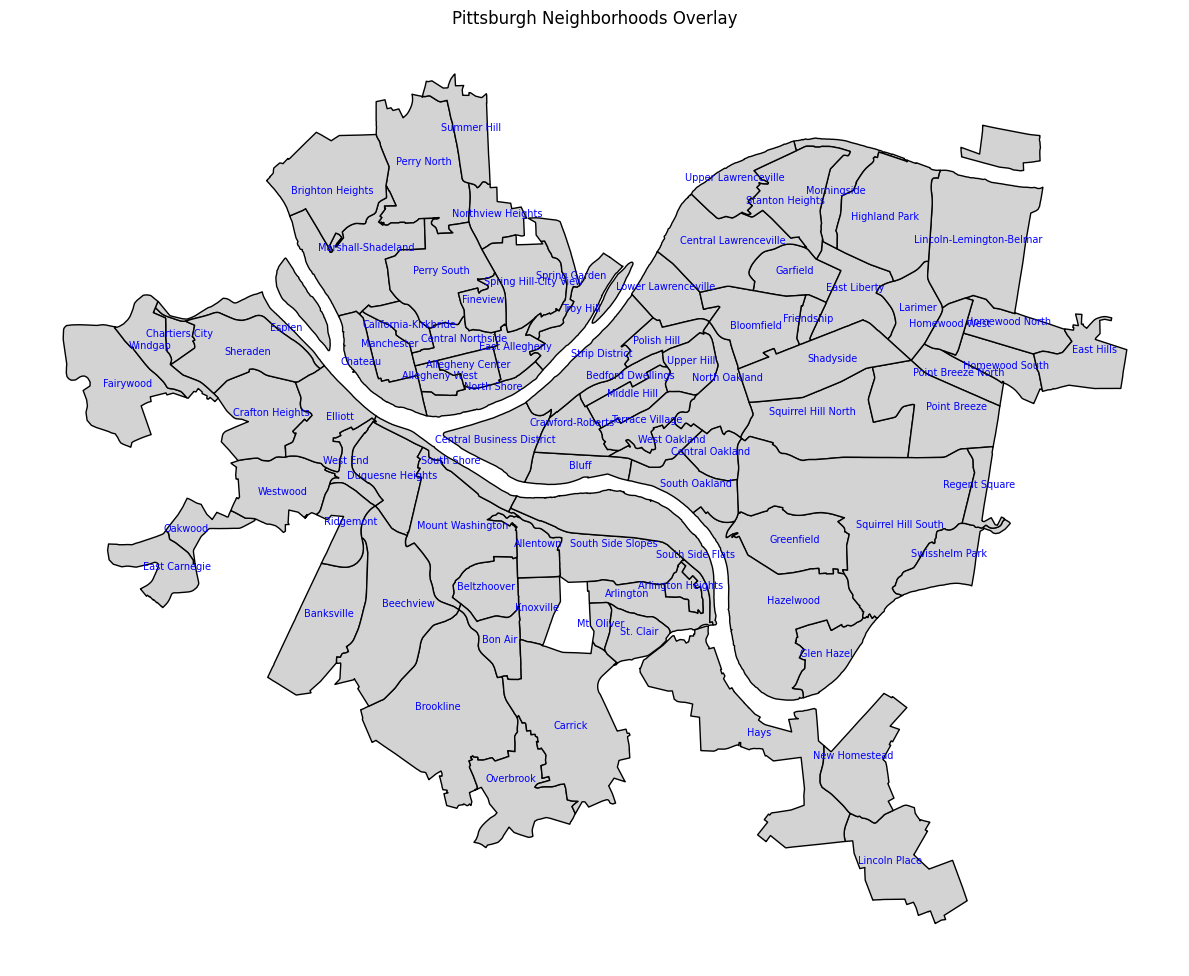

In [42]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


import matplotlib.colors as mcolors



#Get the geojson_file
geojson_fileName="pittsburgh_neighborhoods.geojson"
geojson_filepath=os.path.abspath(geojson_fileName)

#Error Checking to make sure there is a file there
if not os.path.exists(geojson_filepath):
    raise FileNotFoundError(f"GeoJSON file not found: {geojson_filepath}")

# Load the GeoJSON
gdf = gpd.read_file(geojson_filepath)
print("GeoJSON loaded successfully!")


#Options:
#Show the neighborhood names on the map
show_labels=True


##Base MAP

ax = gdf.plot(figsize=(12, 12), color='lightgray', edgecolor='black')

name_col = "hood"


if show_labels:
    for idx, row in gdf.iterrows():
        point = row.geometry.representative_point()
        label = str(row[name_col])
        plt.text(point.x, point.y, label, fontsize=7, ha='center', color='blue')

plt.title("Pittsburgh Neighborhoods Overlay")
plt.axis('off')
plt.tight_layout()
plt.show()



**Lets grab our data**


In [5]:
Sales_data=os.path.join(os.getcwd(),'Sales-transaction-2024-geocoded_with_neighborhood.csv')

# Try to load the data
try:
    # Load the CSV file
    df = pd.read_csv(Sales_data)
    print(f"File  loaded successfully!")
except FileNotFoundError:
    print(f"Error: The file '{Sales_data}' was not found.")
except pd.errors.EmptyDataError:
    print("Error: The file is empty.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

File  loaded successfully!


In [6]:
grouped=df.groupby('neighborhood').size()
print(grouped)

neighborhood
Allegheny Center        3
Allegheny West          3
Allentown              17
Arlington              11
Banksville             10
                       ..
Upper Lawrenceville    22
West End                4
West Oakland           10
Westwood               17
Windgap                 7
Length: 86, dtype: int64


## Chart all of the neighborhoods


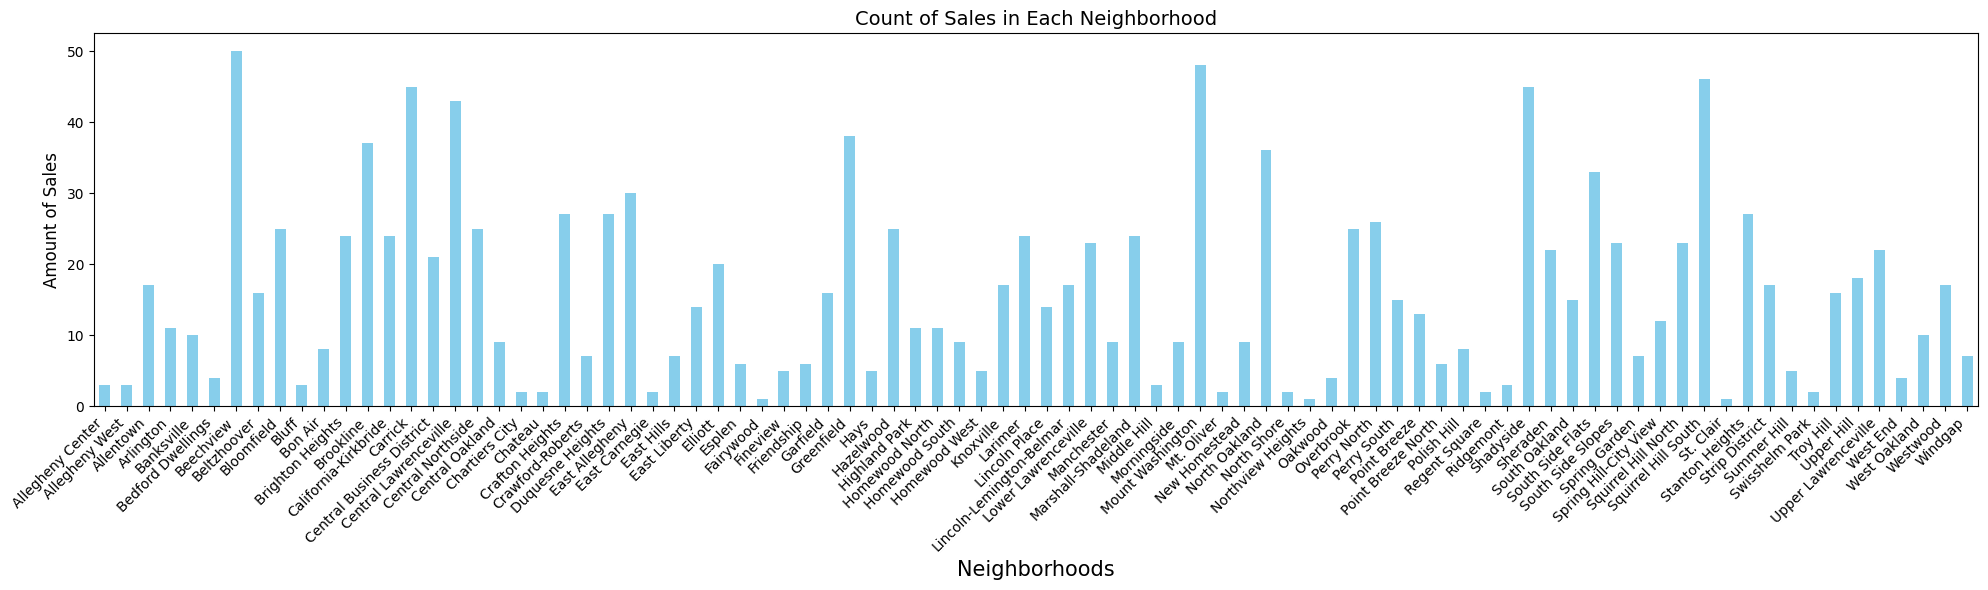

In [25]:
#Make it a graph :)
neighboor_count_sales=grouped

plt.figure(figsize=(20,6))
neighboor_count_sales.plot(kind='bar',color='skyblue')



#This is the labels for the chart

plt.title('Count of Sales in Each Neighborhood',fontsize=14)
plt.xlabel('Neighborhoods',fontsize=15)
plt.ylabel('Amount of Sales',fontsize=12)

plt.xticks(rotation=45,ha='right')


plt.tight_layout()
plt.show()




**Lets get top 10 neighborhoods and get the average of the sale and the cost**

In [35]:
#Lets do the top 5 nieghborhoods that have the most 
Filter_by_Sale_Count=grouped.sort_values(ascending=False)
# print(Filter_by_Sale_Count.head(10))




#Lets get the average for those neighborhoods
top_neighborhood=Filter_by_Sale_Count.head(10).index
top_neighborhood_df=df[df['neighborhood'].isin(top_neighborhood)]


# Lets Get these two in the table
Final_count_avg = top_neighborhood_df.groupby('neighborhood').agg(
    avg_price=('PRICE', 'mean'),
    sale_count=('PRICE', 'count'),
    min_Price =('PRICE' , 'min'),
    max_Price =('PRICE' , 'max'),
    Total_sales=('PRICE','sum')
).sort_values(by='sale_count', ascending=False)
Final_count_avg['avg_price']=Final_count_avg['avg_price'].round(-2)

print(Final_count_avg)


                       avg_price  sale_count  min_Price  max_Price  \
neighborhood                                                         
Beechview               168100.0          50        0.0  1380500.0   
Mount Washington        306500.0          48        0.0  2630000.0   
Squirrel Hill South     418000.0          46        0.0  3000000.0   
Shadyside               628200.0          45        0.0  9338000.0   
Carrick                  94700.0          45        1.0   520000.0   
Central Lawrenceville   326200.0          43        0.0  1795500.0   
Greenfield              120200.0          38        1.0   870000.0   
Brookline               145600.0          37        1.0   339000.0   
North Oakland           217600.0          36        1.0  3359000.0   
South Side Flats        218800.0          33        1.0  1500000.0   

                       Total_sales  
neighborhood                        
Beechview                8404650.0  
Mount Washington        14713334.0  
Squirrel Hi

C:\Users\jag409\AppData\Local\Temp\ipykernel_14356\3223290565.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(Final_count_avg.index, rotation=45, ha='right')


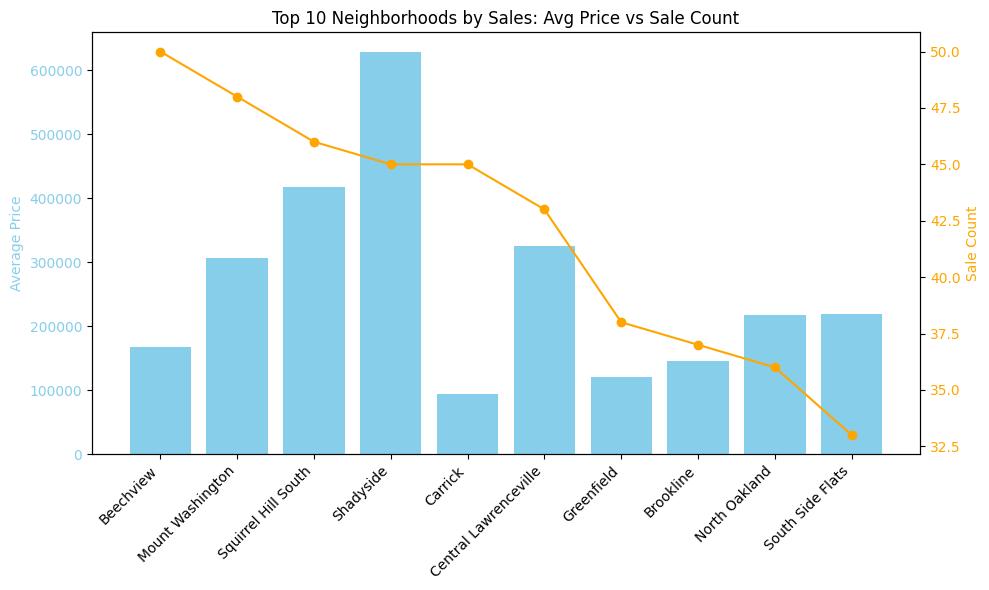

In [ ]:


# Create the bar chart
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar for average price (left y-axis)
ax1.bar(Final_count_avg.index, Final_count_avg['avg_price'], color='skyblue', label='Avg Price')
ax1.set_ylabel('Average Price', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.set_xticklabels(Final_count_avg.index, rotation=45, ha='right')

# Line for sale count (right y-axis)
ax2 = ax1.twinx()
ax2.plot(Final_count_avg.index, Final_count_avg['sale_count'], color='orange', marker='o', label='Sale Count')
ax2.set_ylabel('Sale Count', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Title and layout
plt.title('Top 10 Neighborhoods by Sales: Avg Price vs Sale Count')
plt.tight_layout()
plt.show()


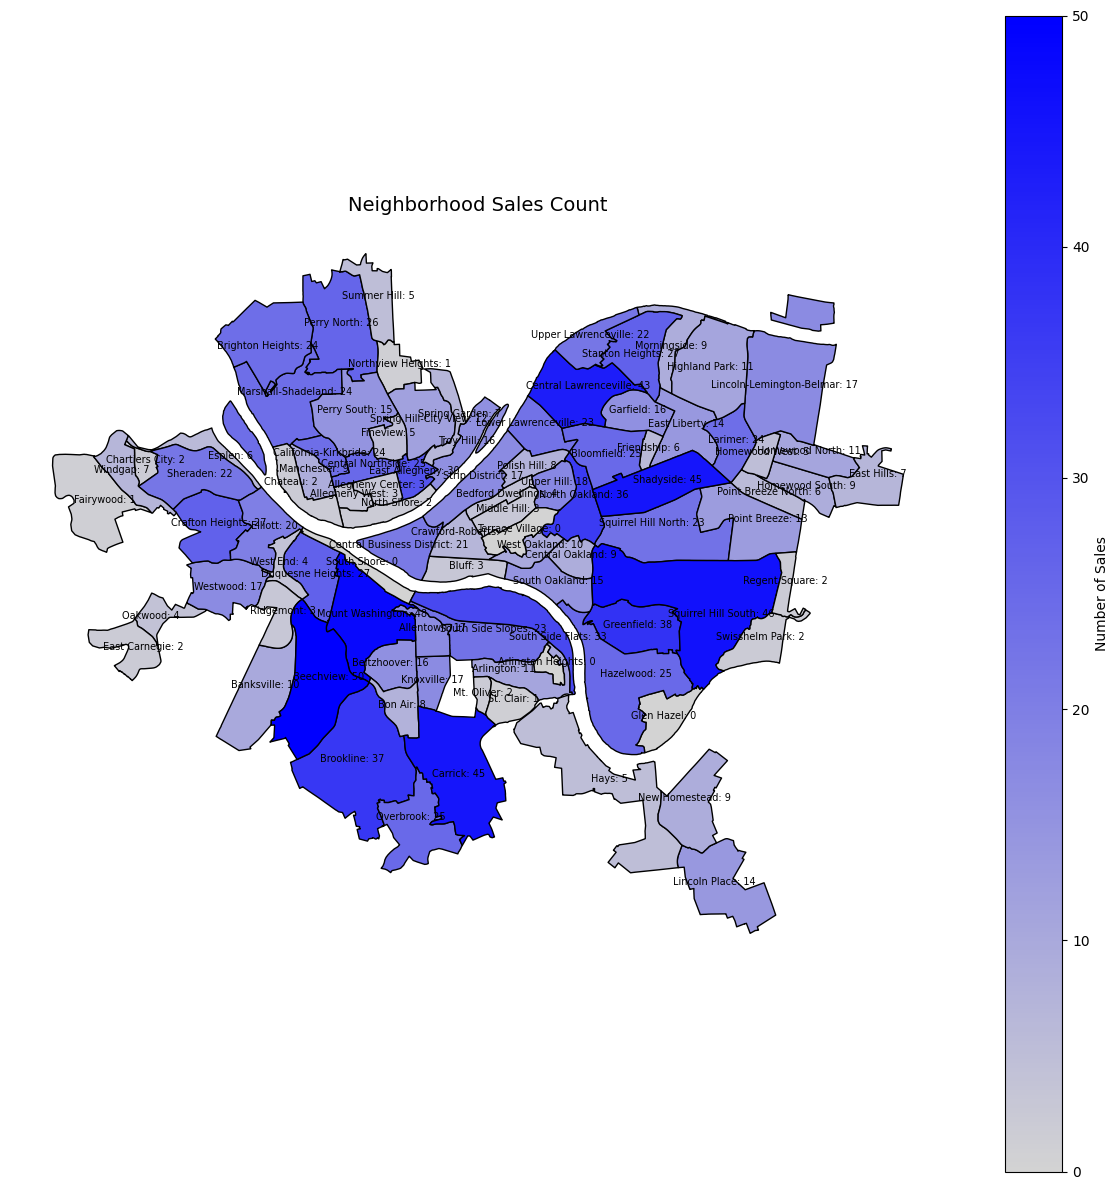

In [44]:
Sales_count_int = grouped
Sales_count_int.name = 'sale_count'


if 'sale_count' in gdf.columns:
    gdf = gdf.drop(columns='sale_count')




gdf = gdf.merge(Sales_count_int, how='left', left_on=name_col, right_index=True)

gdf['sale_count'] = gdf['sale_count'].fillna(0)





#Color


cmap = mcolors.LinearSegmentedColormap.from_list("count_gradient", ["lightgrey", "blue"])
norm = mcolors.Normalize(vmin=gdf['sale_count'].min(), vmax=gdf['sale_count'].max())



fig, ax = plt.subplots(figsize=(12, 12))
gdf.plot(ax=ax, color=gdf['sale_count'].apply(lambda x: cmap(norm(x))), edgecolor='black')


#Do I want to see the labels of the neighboorhoods?
if show_labels:
    for idx, row in gdf.iterrows():
        point = row.geometry.representative_point()
        label = f"{row['hood'].title()}: {int(row['sale_count'])}"
        ax.text(point.x, point.y, label, fontsize=7, ha='center', color='Black')



#I do need the color bar here
sm=plt.cm.ScalarMappable(cmap=cmap,norm=norm)
sm.set_array([])
fig.colorbar(sm,ax=ax,label='Number of Sales')
plt.title("Neighborhood Sales Count", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()


